# Linear and Logistic regression assignment

In [8]:
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LinearRegression, LogisticRegression
from sklearn.metrics import mean_absolute_error, accuracy_score
from sklearn.metrics import confusion_matrix
from ucimlrepo import fetch_ucirepo
import matplotlib.pyplot as plt
import seaborn as sns

## Business Understanding

The goal of this assignment is to explore and apply linear and logistic regression models to a real-world dataset. Linear regression is used to model and predict continuous values, while logistic regression is applied to a classification task derived from the same dataset. The objective is to understand how these models work, how they are trained and how their perfomance can be evaluated using appropriate metrics.

The objectives of this assignment are:

- to learn to use linear regression for predicting continuously varying target variables
- to learn to use logistic regression for binary classification
- to learn to estimate the relative importance of input features


## Data understanding

We start by fetching the dataset and printing out the first few rows

In [9]:
# fetch dataset
real_estate_valuation = fetch_ucirepo(id=477)
# data (as pandas dataframes)
data = real_estate_valuation.data.original
data = data.drop(columns=['No'])

data.head()

,X1 transaction date,X2 house age,X3 distance to the nearest MRT station,X4 number of convenience stores,X5 latitude,X6 longitude,Y house price of unit area
0,2012.917,32.0,84.87882,10,24.98298,121.54024,37.9
1,2012.917,19.5,306.59470,9,24.98034,121.53951,42.2
2,2013.583,13.3,561.98450,5,24.98746,121.54391,47.3
3,2013.500,13.3,561.98450,5,24.98746,121.54391,54.8
4,2012.833,5.0,390.56840,5,24.97937,121.54245,43.1


This dataset clearly contains information/measurements about various houses and their corresponding market values.

The features in the dataset are as follows:
- 'No': A unique identifier for each house (we will not use this feature in modeling)
- 'X1 transaction date': The transaction date (for example, 2013.250 = March 2013)
- 'X2 house age': The age of the house (in years)
- 'X3 distance to the nearest MRT station': The distance to the nearest MRT (Mass Rapid Transit) station
- 'X4 number of convenience stores': The number of convenience stores in the vicinity
- 'X5 latitude': The latitude coordinate of the house location
- 'X6 longitude': The longitude coordinate of the house location
- 'Y house price of unit area': The market price of the house per unit area

Our clear target variable is 'Y house price of unit area', which we will try to predict using the other features in the dataset.

In [10]:
data.describe()

,X1 transaction date,X2 house age,X3 distance to the nearest MRT station,X4 number of convenience stores,X5 latitude,X6 longitude,Y house price of unit area
count,414.000000,414.000000,414.000000,414.000000,414.000000,414.000000,414.000000
mean,2013.148971,17.712560,1083.885689,4.094203,24.969030,121.533361,37.980193
std,0.281967,11.392485,1262.109595,2.945562,0.012410,0.015347,13.606488
min,2012.667000,0.000000,23.382840,0.000000,24.932070,121.473530,7.600000
25%,2012.917000,9.025000,289.324800,1.000000,24.963000,121.528085,27.700000
50%,2013.167000,16.100000,492.231300,4.000000,24.971100,121.538630,38.450000
75%,2013.417000,28.150000,1454.279000,6.000000,24.977455,121.543305,46.600000
max,2013.583000,43.800000,6488.021000,10.000000,25.014590,121.566270,117.500000


After studying the basic statistics of the dataset we can see that the average house price per unit area is around 37.98. Something else that could be interesting to note is that the average age of the houses in the dataset is around 17.7 years, and the average distance to the nearest MRT station is around 1083 (presumably in meters). The number of convenience stores in the vicinity varies from 0 to 10, with an average of around 4.1 stores.

Next we wanna see how the different features correlate with the target variable (house price of unit area). We are looking for values that are close to 1 or -1 as they indicate strong positive or negative correlation respectively.

In [11]:
# Calculate the correlation matrix
correlation_matrix = data.corr()
# Display the correlation of each feature with the target variable
target_correlation = correlation_matrix['Y house price of unit area'].sort_values(ascending=False)
print(target_correlation)

Y house price of unit area                1.000000
X4 number of convenience stores           0.571005
X5 latitude                               0.546307
X6 longitude                              0.523287
X1 transaction date                       0.087491
X2 house age                             -0.210567
X3 distance to the nearest MRT station   -0.673613
Name: Y house price of unit area, dtype: float64


When we are looking at the features and their correlations with the target variable, we can also visualize the relationships using scatter plots. This can help us to see if there are any patterns or trends in the data. Lets create a scatter plot for each feature against the target variable 'Y house price of unit area'.

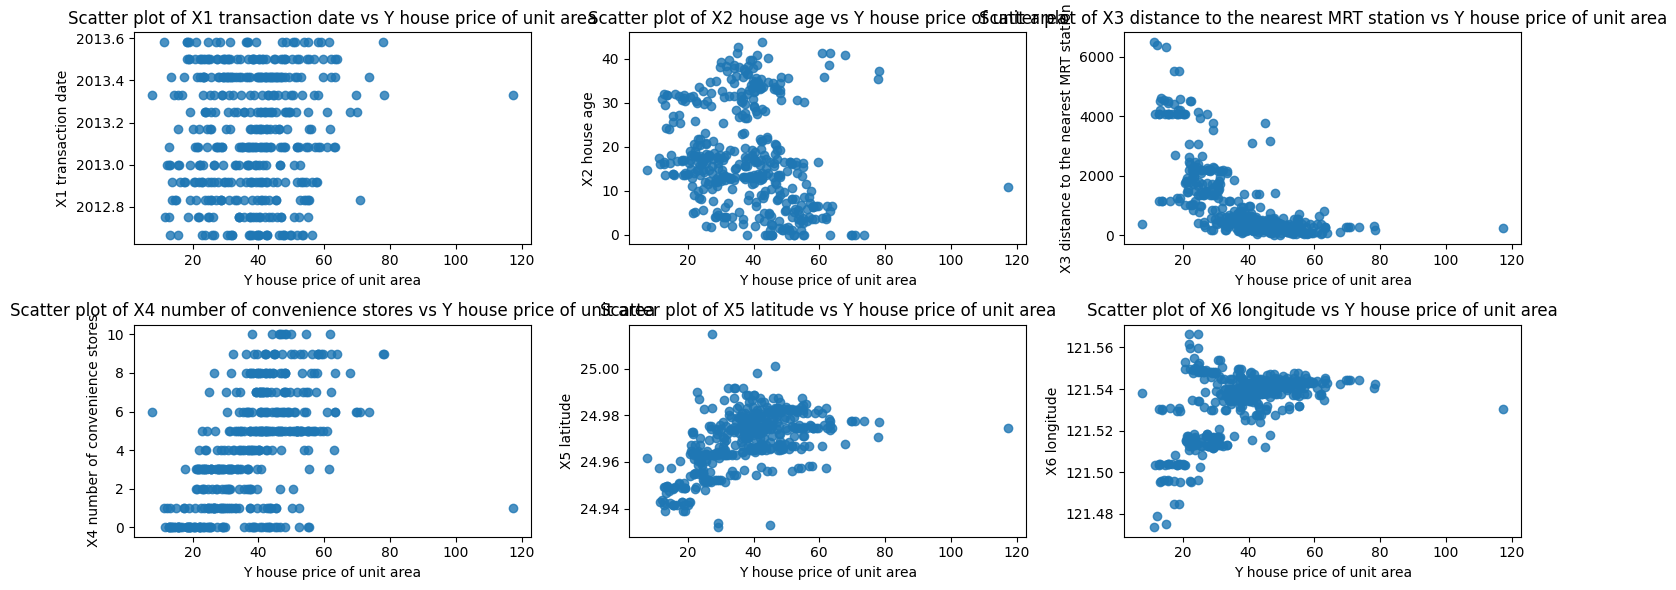

In [12]:
# Creating scatter plots for each feature against the target variable where the feature is on the y-axis and the target variable is on the x-axis
features = data.columns.drop('Y house price of unit area')
target = 'Y house price of unit area'
fig, axes = plt.subplots(2, 3, figsize=(15, 6))
axes = axes.flatten()
for i, feature in enumerate(features):
    ax = axes[i]
    ax.scatter(data[target], data[feature], alpha=0.8)
    ax.set_xlabel('Y house price of unit area')
    ax.set_ylabel(feature)
    ax.set_title(f'Scatter plot of {feature} vs {target}')
plt.tight_layout()
plt.show()

From the visual scatter plots we can immediately see that it's much harder to identify clear linear relationships between the features and the target variable compared to the correlation numbers we saw earlier. However, we can still observe some trends:
- Both latitude and longitude seem to have some kind of relationship with the house price per unit area. This makes sense as the location of a house often affects the price.
- While hard to see, there is a slight positive trend between the number of convenience stores and the house price per unit area, which aligns with the positive correlation we observed earlier.

## Data preparation

Before we start to go through the data we can make a statement that this dataset does not contain any missing values.

## Modeling

## Evaluation

## Deployment